## TODO


### Imports

In [23]:
import pandas
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [100,20]
np.set_printoptions(suppress=True)

In [2]:
path = "~/work/data/producer-648hk/2020-09-14_15-06-42"
topic = "t4"
full_path = path + "/" + topic

## Filter

In [3]:
def dropFirstXRows(input, x):
    return input.drop(np.arange(0,x))

def removeNaN(array):
    return array[np.logical_not(np.isnan(array))]

In [4]:
produced_generated_df = pandas.read_csv(full_path + "_produced.csv")
produced_recieved_df = pandas.read_csv(full_path + ".csv")
filtered_df = pandas.read_csv(full_path + "_filtered.csv")
warnings_df = pandas.read_csv(full_path + "_warnings.csv")
modelchange_df = pandas.read_csv(full_path + "_modelchange.csv")

elementsToDrop = 0#10000
produced_generated_df = dropFirstXRows(produced_generated_df,elementsToDrop)
produced_recieved_df = dropFirstXRows(produced_recieved_df,elementsToDrop)
filtered_df = dropFirstXRows(filtered_df,elementsToDrop)

#drop changes before first element
#modelchange_df = modelchange_df[modelchange_df.iloc[:,0] >= produced_generated_df.iloc[0][2]]

# drop endtime in warning before first element
#warnings_df = warnings_df[warnings_df.iloc[:,6] >= produced_generated_df.iloc[0][2]]

### Helper

In [5]:
def plotDistribution(data):
    plt.scatter(np.arange(1,len(data) + 1,1), data, s = 1)
    plt.plot(np.arange(1,len(data) + 1,1), data)
    #plt.yscale("log")
    #plt.ylim(0,10)
    #plt.xlim(0,100)
    plt.show()
    
    sorted = np.sort(data)
    plt.yscale("log")

    plt.plot(np.linspace(0, 1,len(sorted),endpoint=True), sorted)
    plt.show()

In [6]:
def extractAvgMedStdMinMaxFromArray(diff):
    plotDistribution(diff)
    return np.average(diff), np.median(diff), np.std(diff), np.min(diff), np.max(diff)

### Histogram of generated data over time

consumer & produducer timestamp of the produced data

data isn't produced every 5ms instead there are peaks and lows, just the avg is 5ms

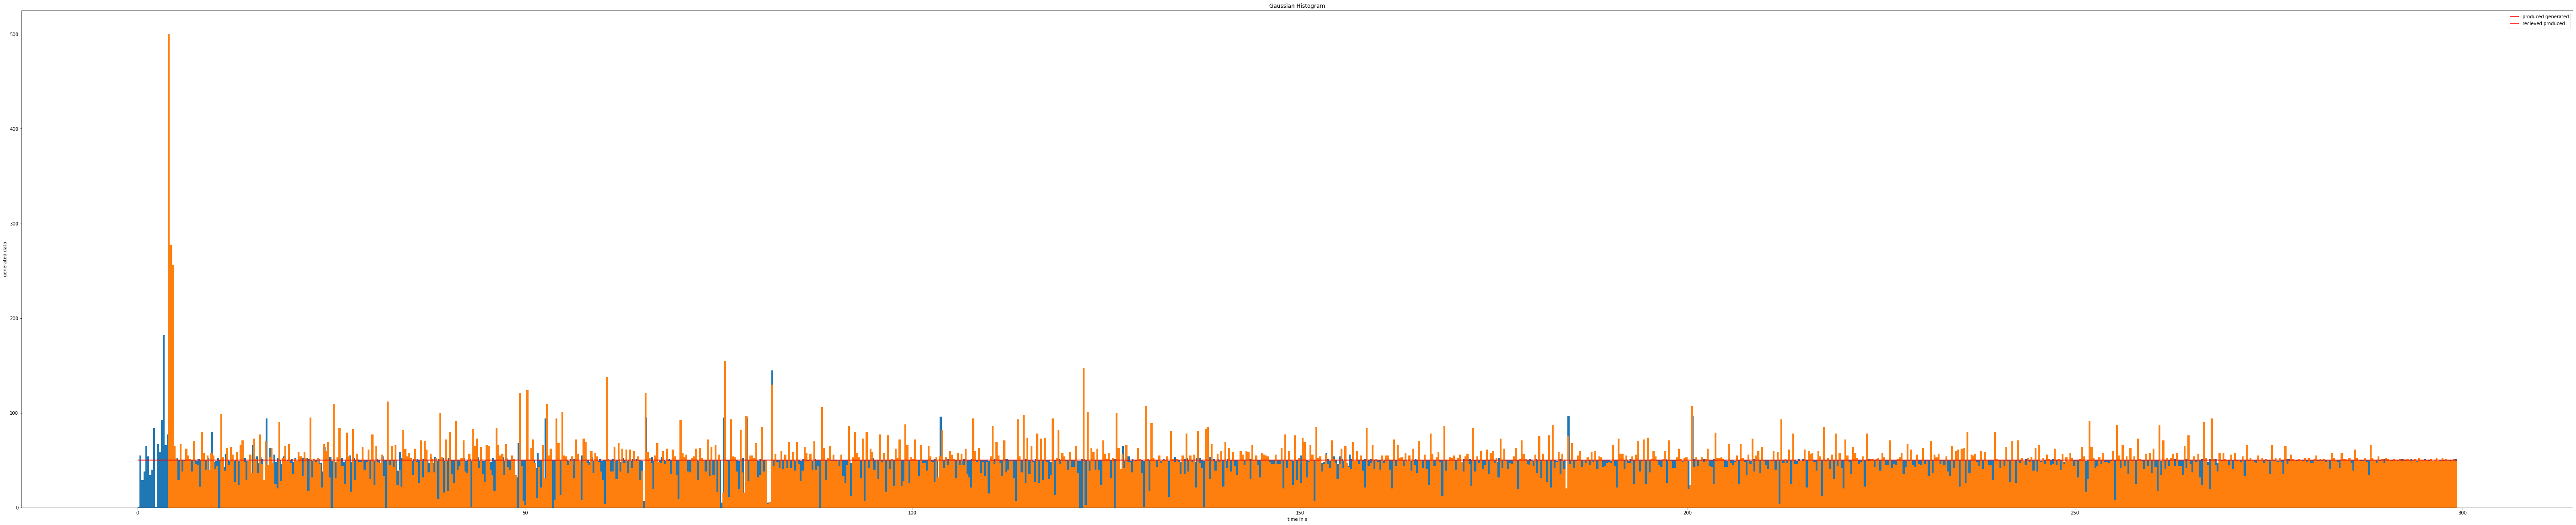

In [7]:
def plotHist(data, substractTime, label, width = 250):
    timespan = data[-1] - data[0]
    
    
    
    plt.hist((data - substractTime) / 1000, bins = int(timespan / width))
    plt.hlines(width / 5, 0, (data[-1] - substractTime) / 1000, color = "red", label = label)
    plt.title("Gaussian Histogram")
    plt.xlabel("time in s")
    plt.ylabel("generated data")
    plt.legend()
    #plt.show()

producedTime = produced_generated_df.to_numpy()[:,3]
#print("Produced data distribution")
plotHist(producedTime, producedTime[0], "produced generated") 
#print("Recieved produced data distribution")
plotHist(produced_recieved_df.to_numpy()[:,0], producedTime[0], "recieved produced")
plt.show()



### Information on the time difference between the arival time of records for all 3 topics

peaks caused by cpu time, it is not regulary produced

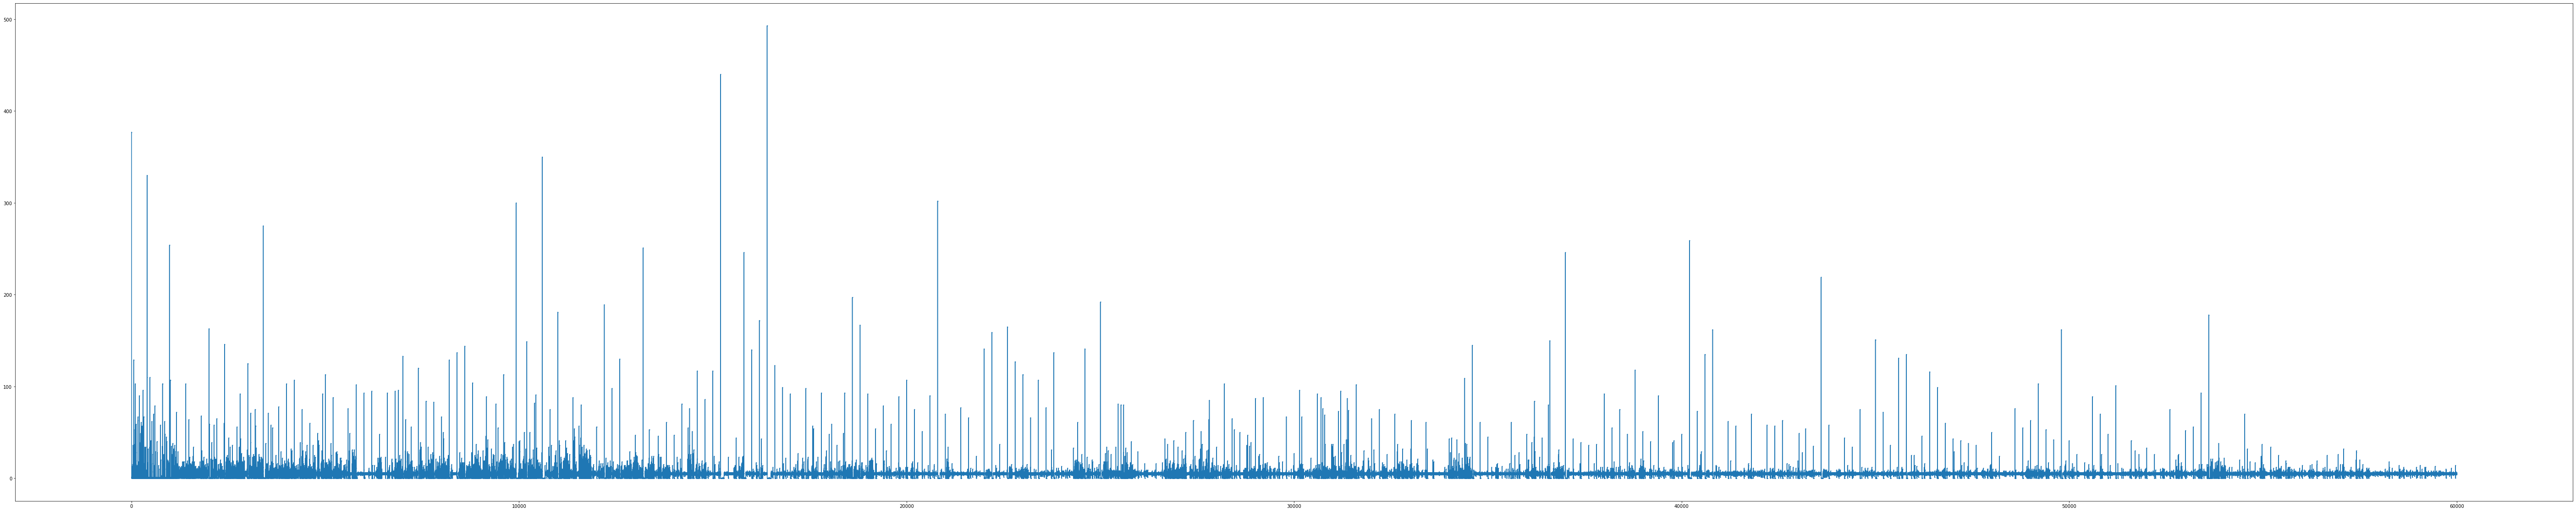

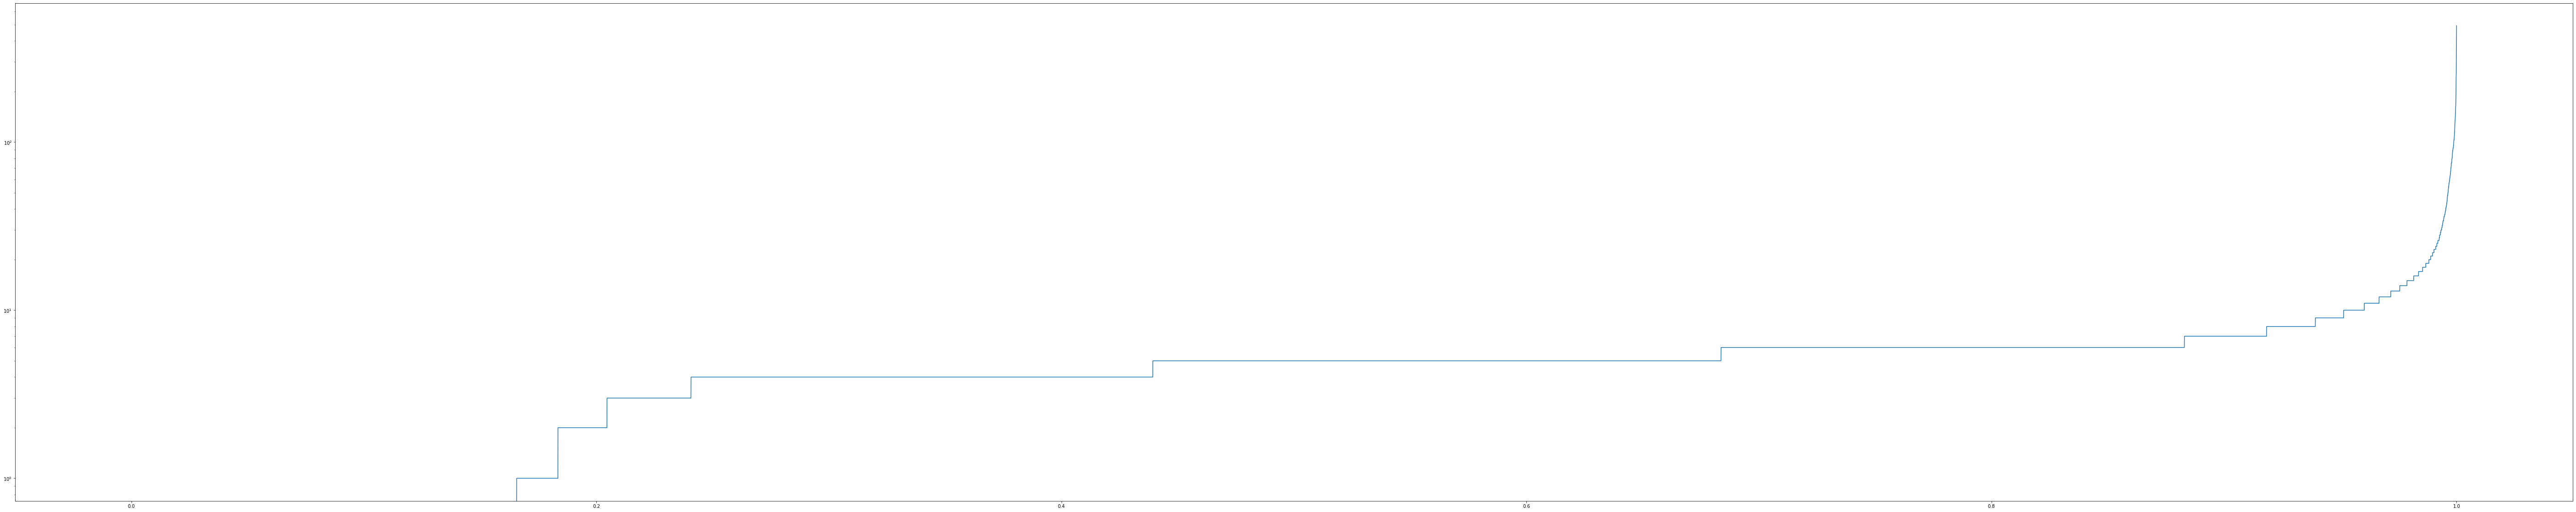

produced:
Got in average every 4.99 ms new data, with median 5.00, and std = 8.02, further min was 0 and max 493




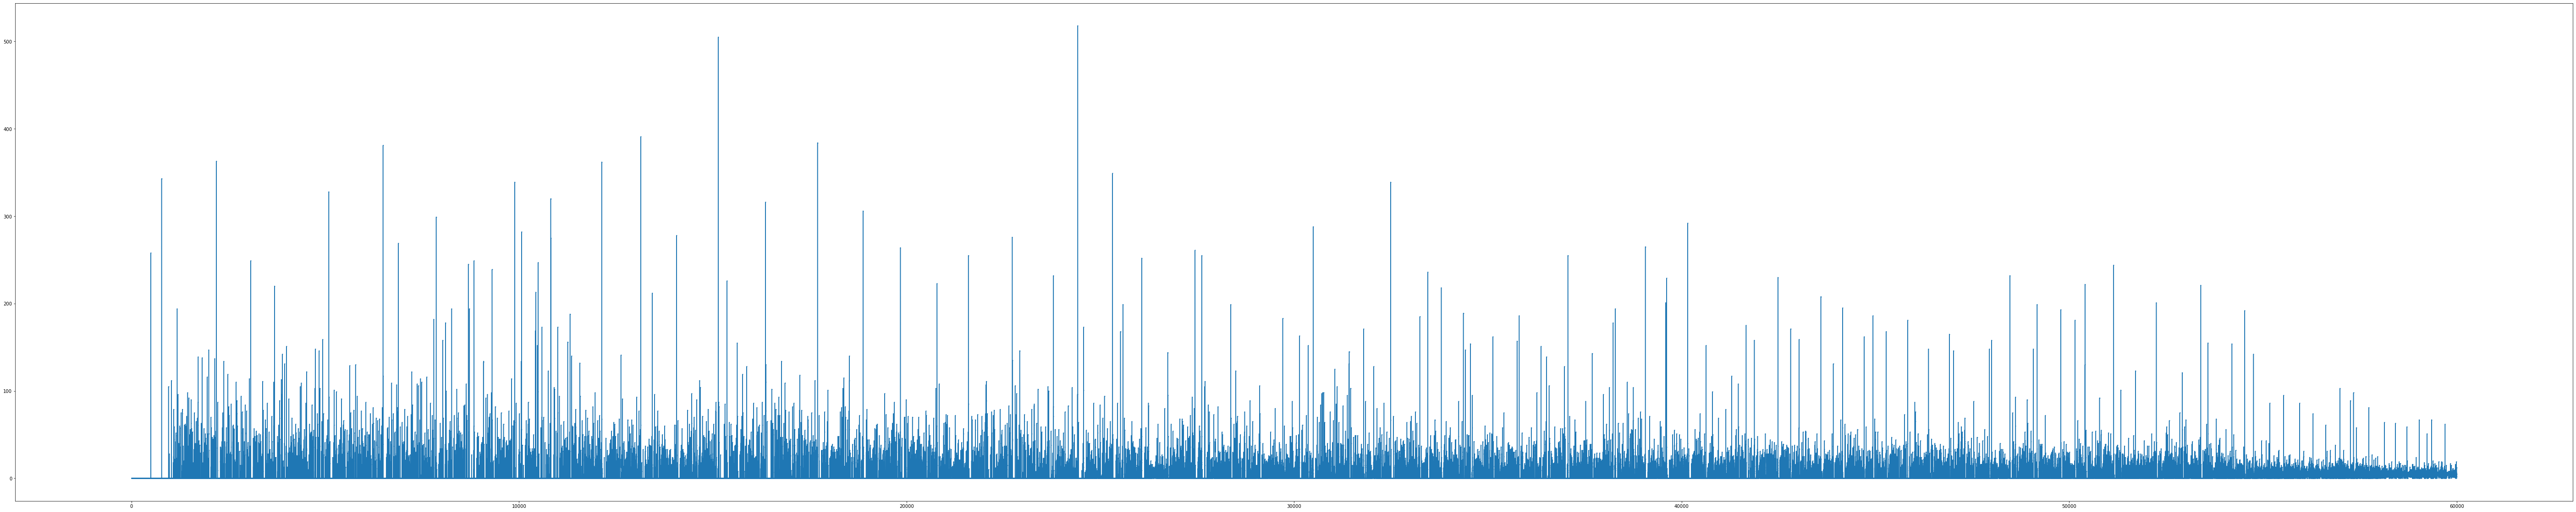

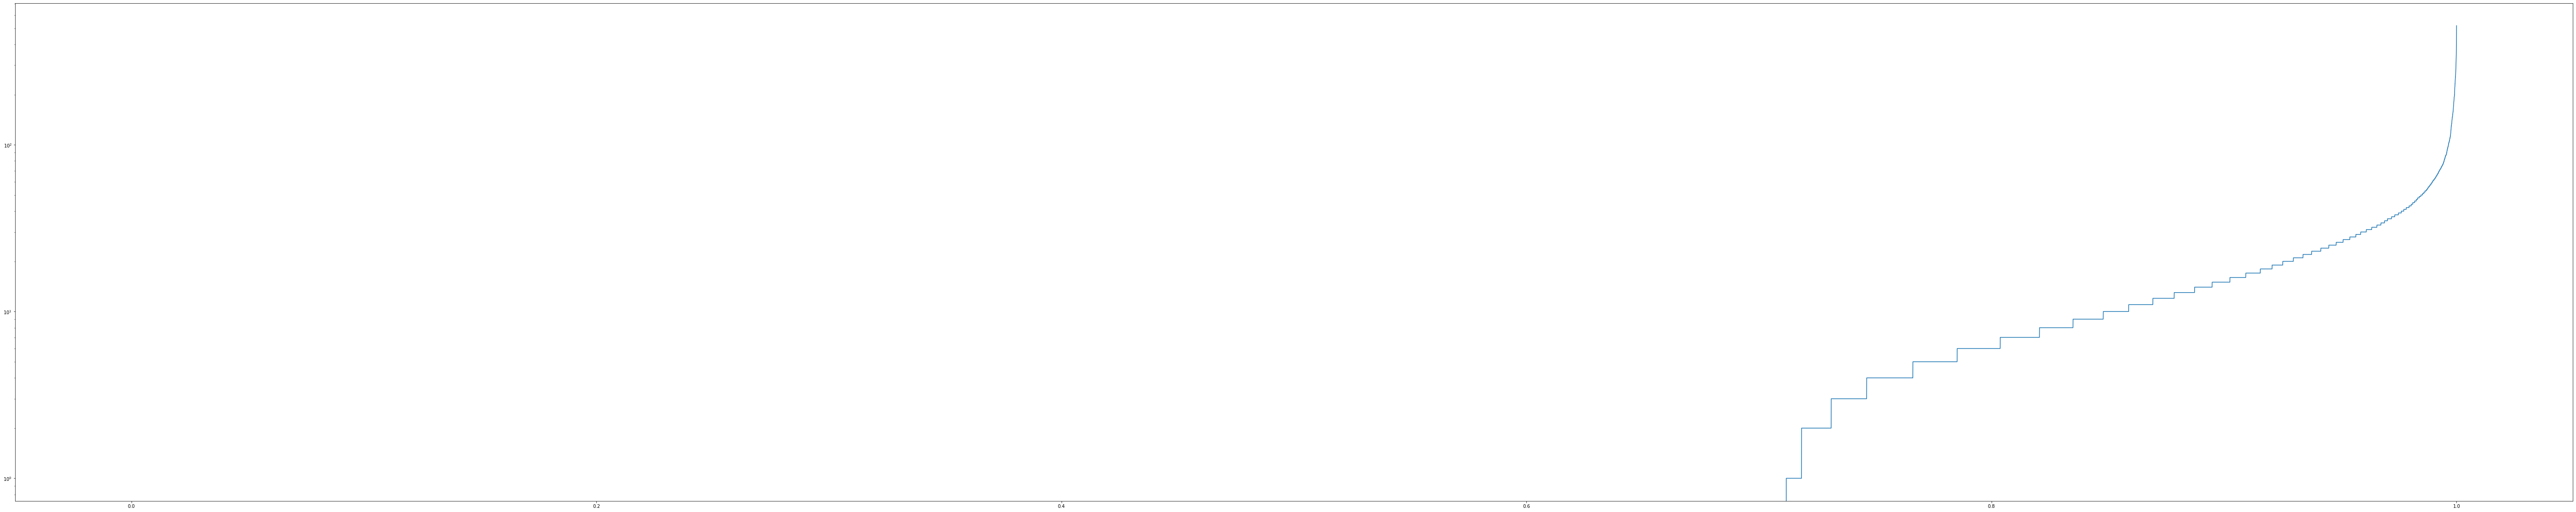

produced received:
Got in average every 4.92 ms new data, with median 0.00, and std = 15.14, further min was 0 and max 518




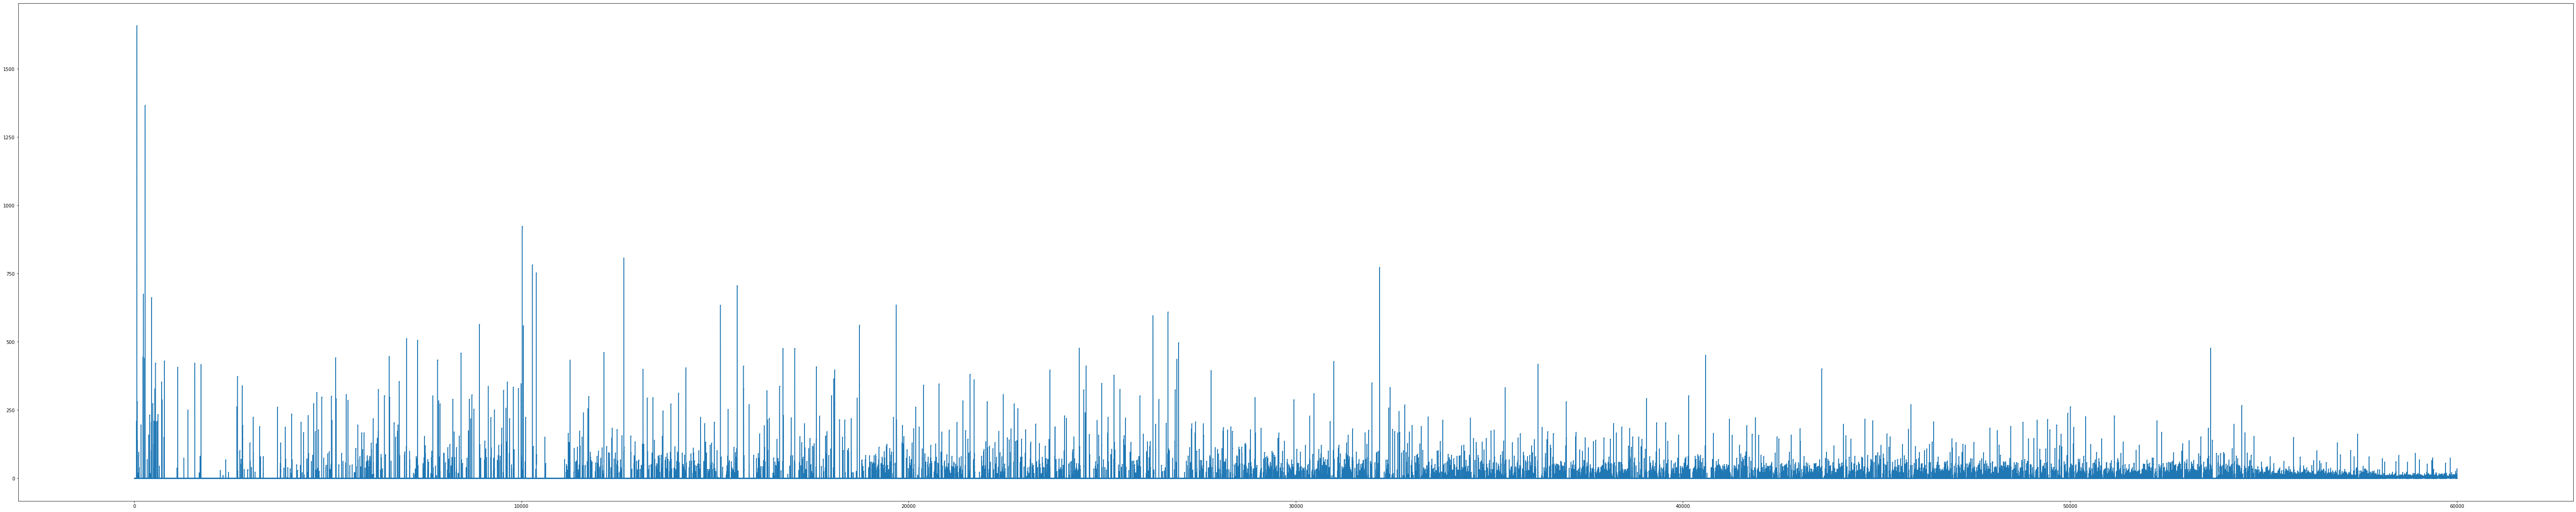

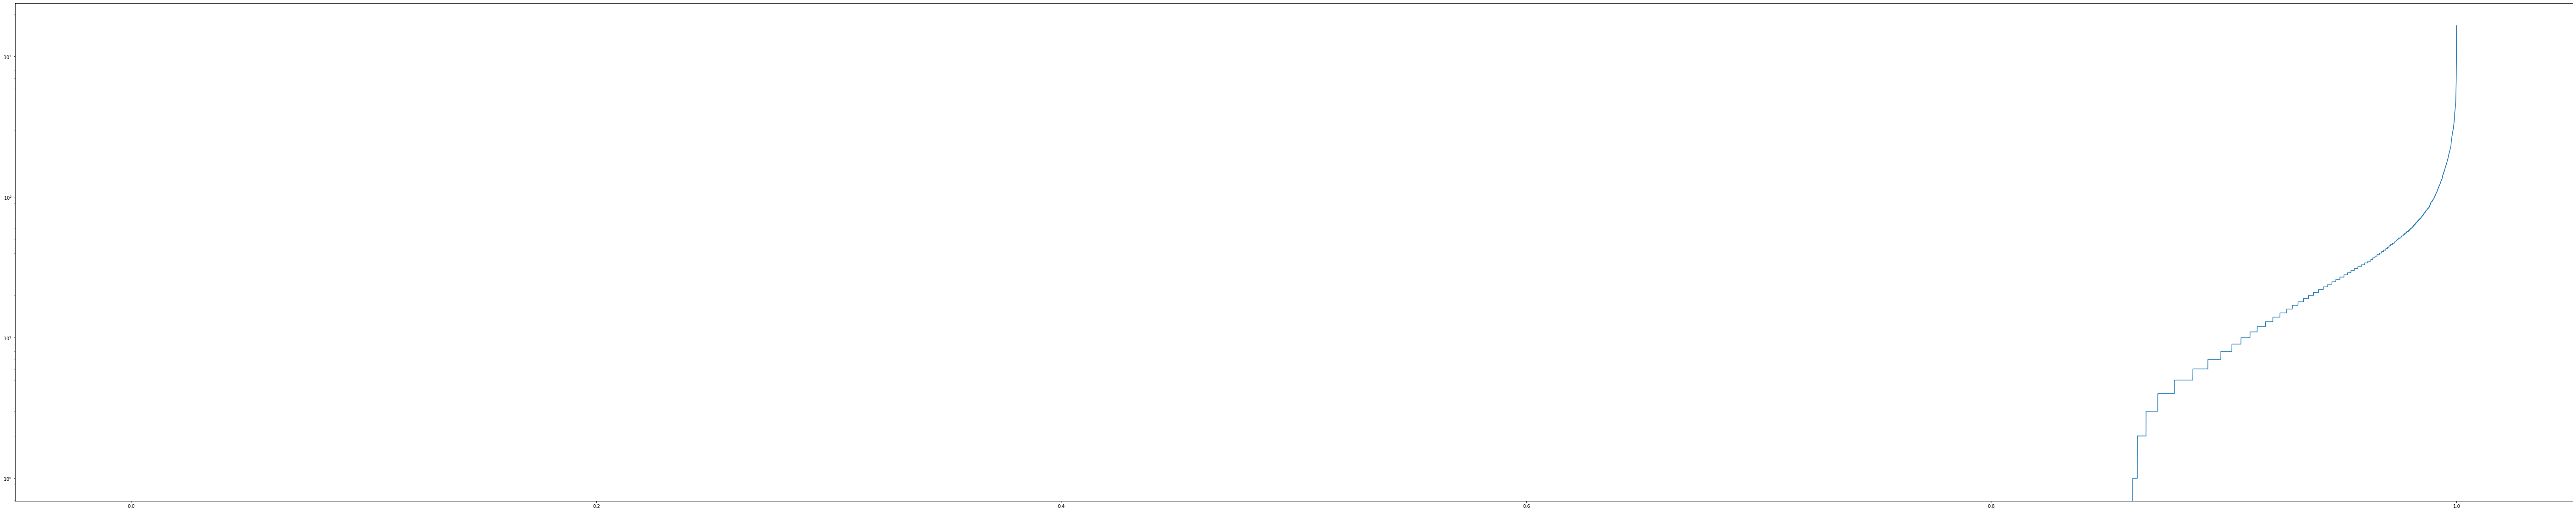

filtered:
Got in average every 4.93 ms new data, with median 0.00, and std = 26.67, further min was 0 and max 1658




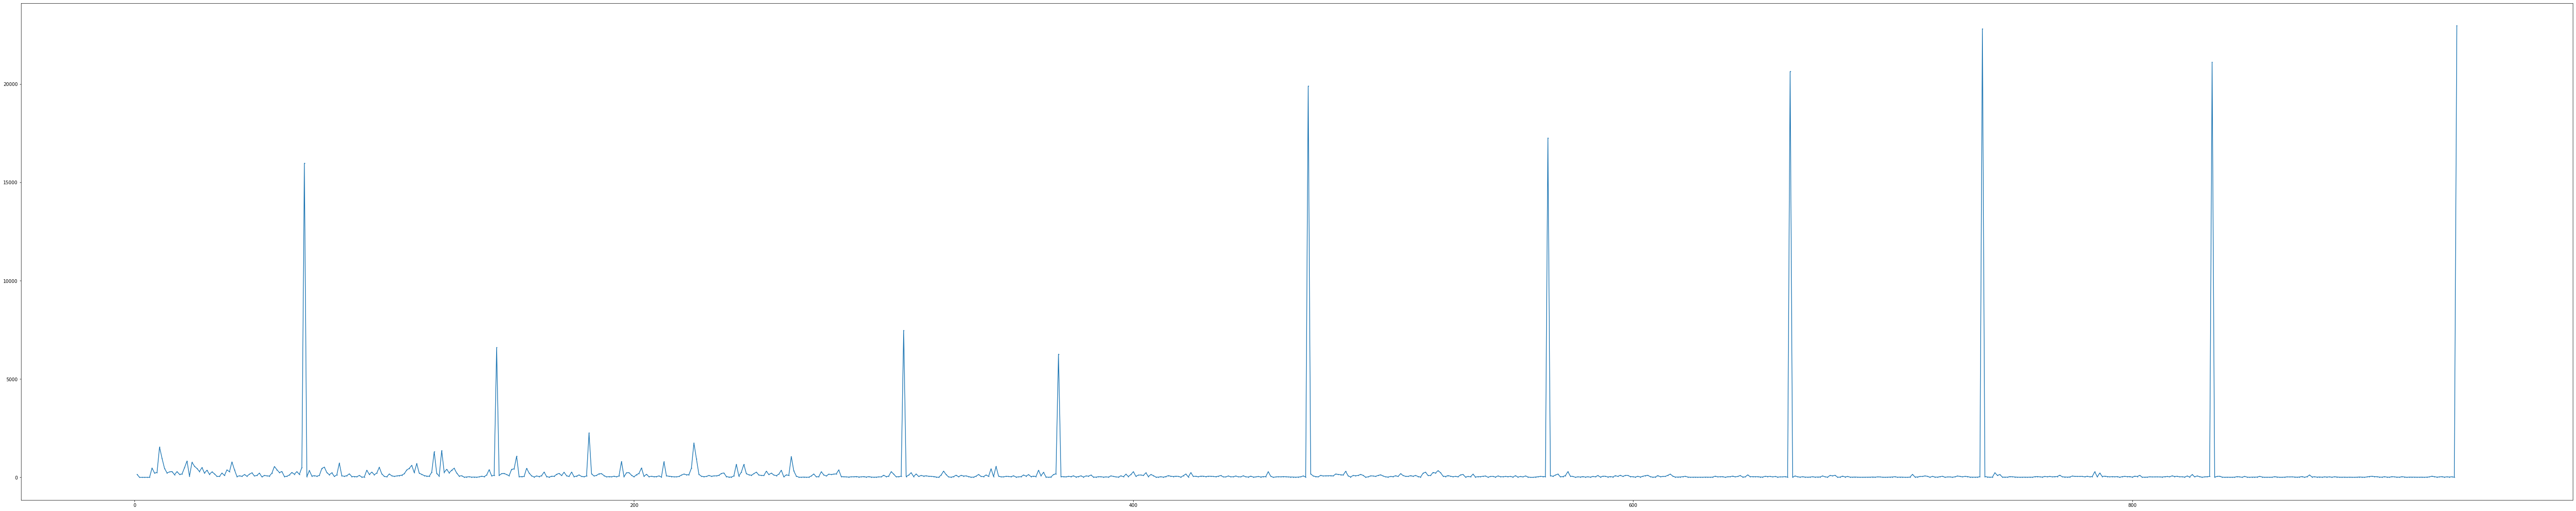

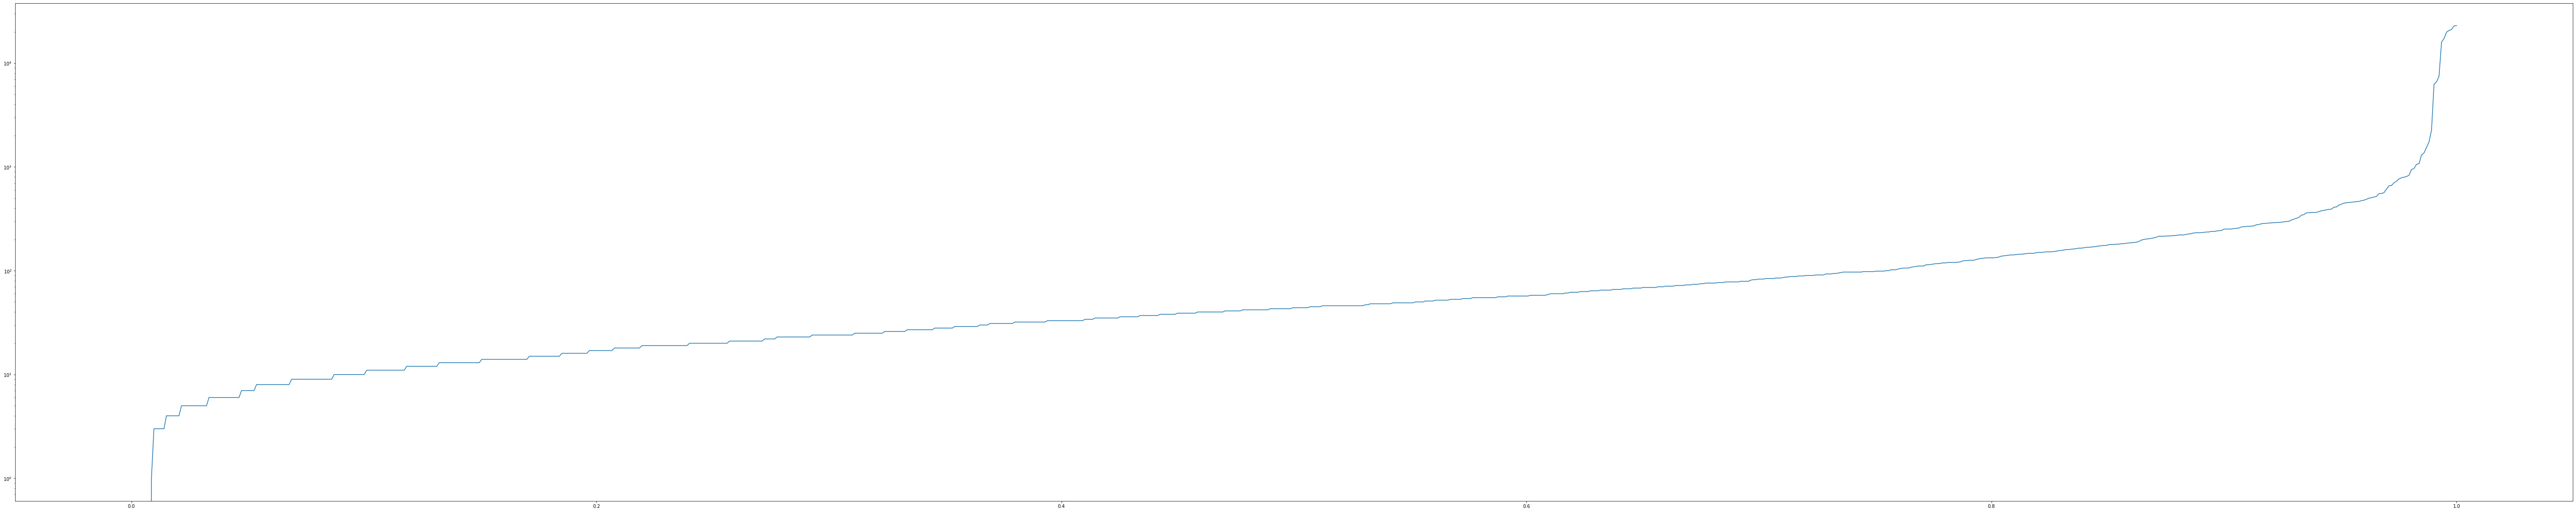

Got in average every 270.44 ms new data, with median 44.00, and std = 1788.74, further min was 0 and max 22965




In [8]:
def avgMedStdArivalTime(df, column):
    df = df.to_numpy()[:,column].astype(int)
    #print(df)
    diff = df[1:,]-df[:-1,]
          
    return extractAvgMedStdMinMaxFromArray(diff)
    
def getArivalInfos():
    text = "%s:\nGot in average every %.2f ms new data, with median %.2f, and std = %.2f, further min was %d and max %d\n\n"
    print(text %("produced", *avgMedStdArivalTime(produced_generated_df, 3)))
    print(text %("produced received", *avgMedStdArivalTime(produced_recieved_df, 0)))
    print(text %("filtered", *avgMedStdArivalTime(filtered_df, 0)))
    print(text %("warning", *avgMedStdArivalTime(warnings_df, 0)))
    
getArivalInfos()

## Check Produced

### How long does it take until a produced record is acknowledged by kafka

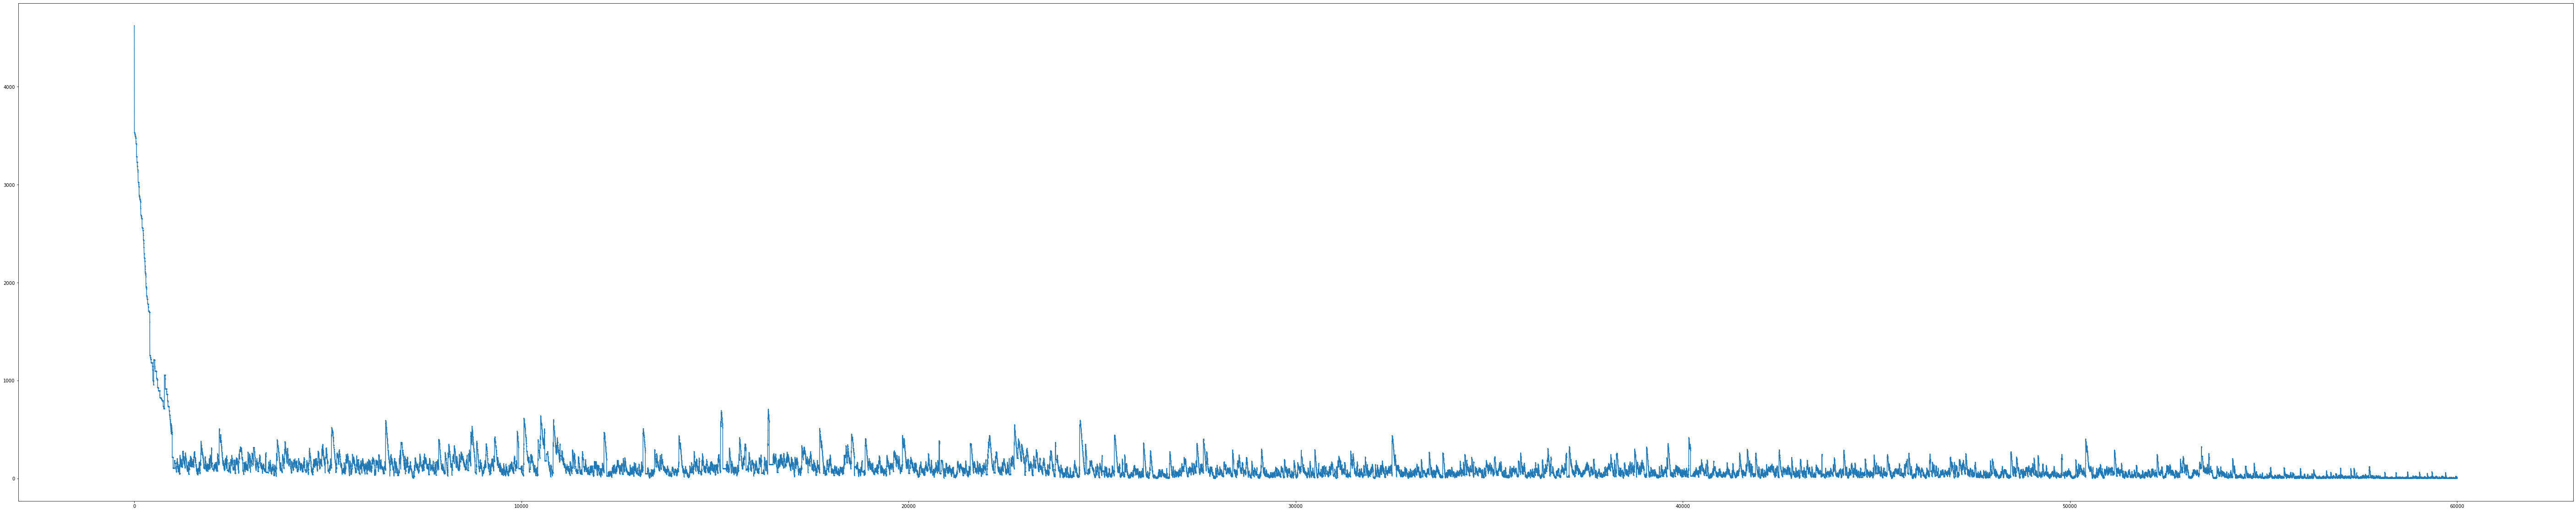

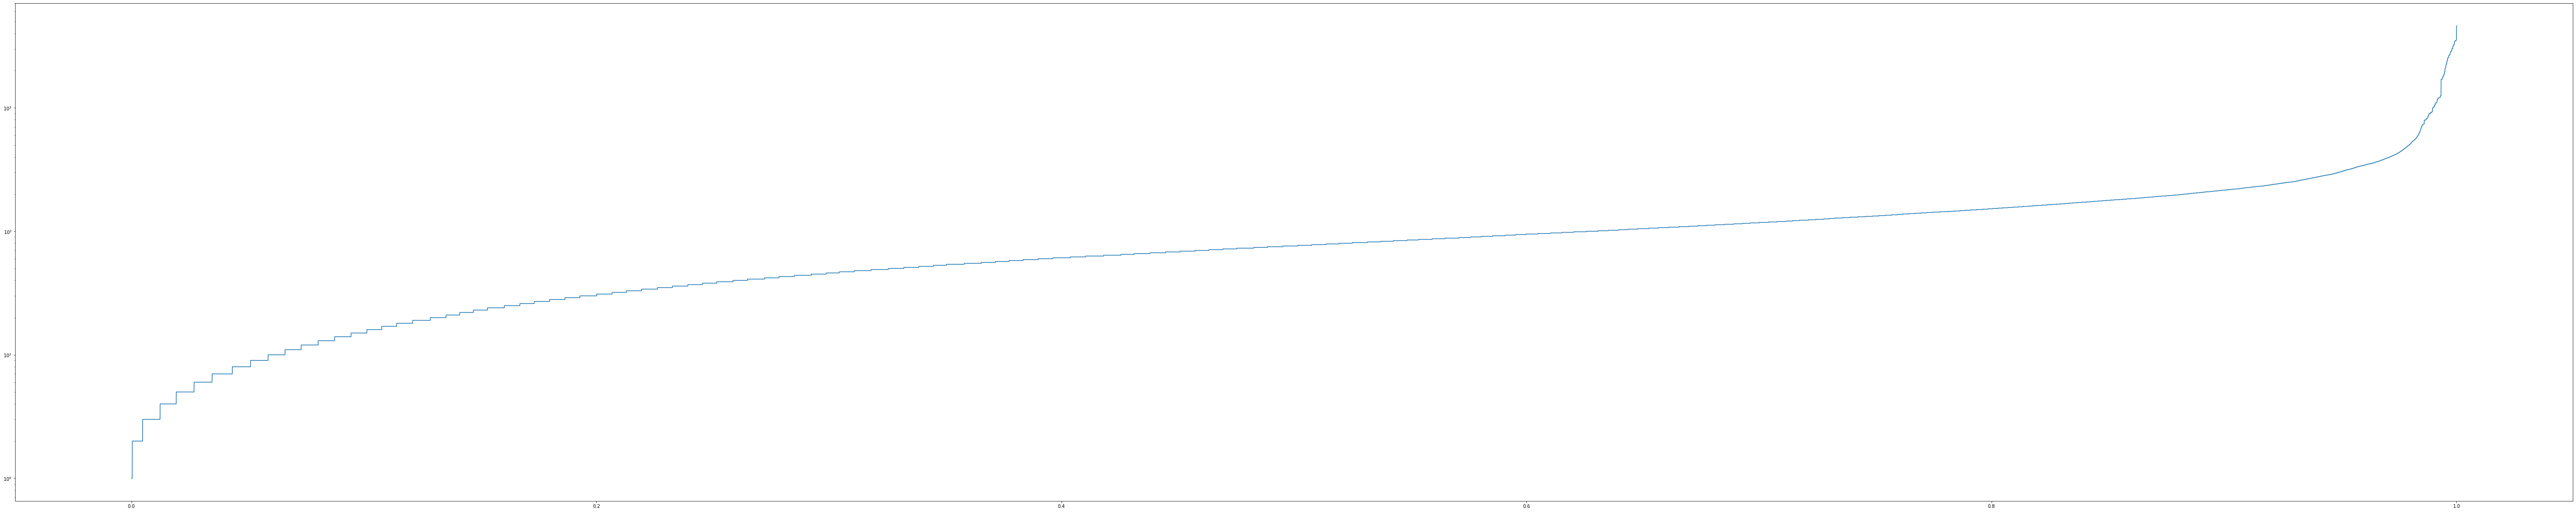

Produced data was received by Kafka after: avg = 121.30 ms; median 76.00 ms; std = 238.96 ms, further min was 1 ms and max 4623 ms


In [9]:
def kafkaAck(df):
    ack = df.to_numpy()[:,0].astype(int)
    send = df.to_numpy()[:,3].astype(int)
    diff = ack - send
    return extractAvgMedStdMinMaxFromArray(diff)
    
print("Produced data was received by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %kafkaAck(produced_recieved_df))

### check validity of produced data

In [10]:
def validate(df):
    df = df.to_numpy()[:,0:4]
    
    lastRow = df[0]
    error = False
    
    l = len(df)
    
    f = IntProgress(min=0, max=100) # instantiate the bar
    display(f)
    i = 0
    
    for x in df[1:]:
        
        i += 1
        cp = int((i / float(l)) * 100)
        
        f.value = cp
            
        if(np.sum(x >= lastRow) != 4):
            error = True
            print("Error:")
            print(lastRow)
            print(x)
        if(lastRow[2] + 1 != x[2]):
            print("Offset %i increased not by 1" %lastRow[2])
            
        lastRow = x
    if(not error):
        print("Valid")
        
    f.value = 100
        
validate(produced_recieved_df)

IntProgress(value=0)

Valid


### Time between the last step and the next

Produced -> Filtered


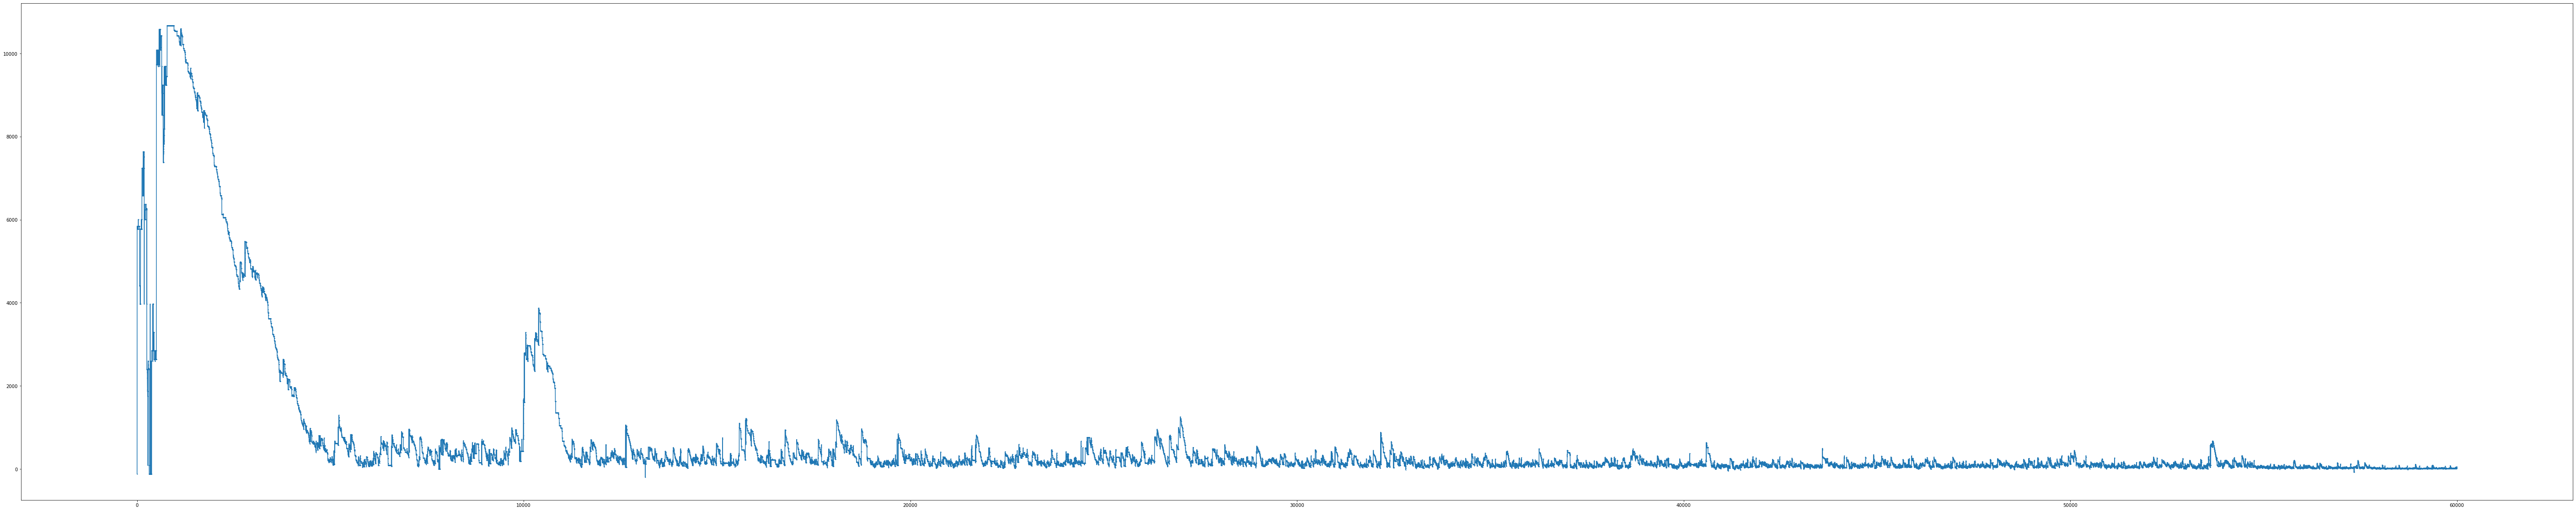

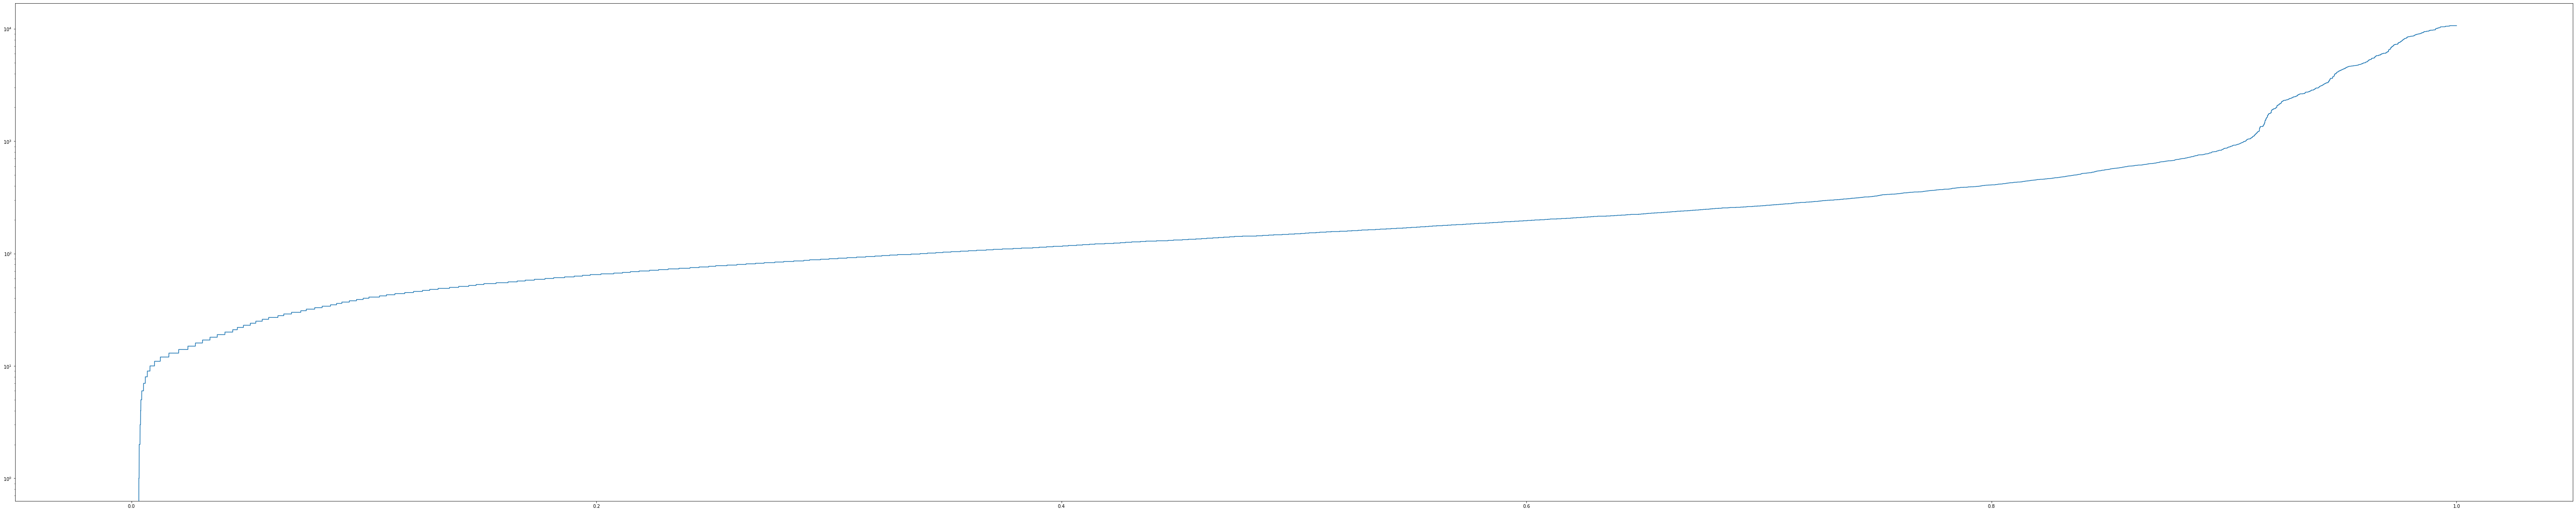

Filtered data was received by a consumer after the produced data was received: avg = 648.73 ms; median 149.00 ms; std = 1713.03 ms, further min was -201 ms and max 10670 ms


In [11]:
def extractDiffBetweenTwoTables(a,b,keyA,keyB, sortBy, valueA, valueB):
    joined = a.set_index(keyA).add_prefix('a_').join(b.set_index(keyB).add_prefix('b_')).sort_values("b_" + sortBy, ascending = True)

    diff = joined['a_' + valueA].to_numpy() - joined['b_' + valueB].to_numpy()
    
    return diff, joined

print("Produced -> Filtered")
diff, _ = extractDiffBetweenTwoTables(filtered_df, produced_recieved_df, 'Data.Offset', 'Kafka.Offset', "Consumer.Time", 'Consumer.Time', 'Consumer.Time')
print("Filtered data was received by a consumer after the produced data was received: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %extractAvgMedStdMinMaxFromArray(diff))

Negative values are possible, a node can receive the warnings before the filtered, it depends on the position in cluster an other aspects

Filtered -> Warning


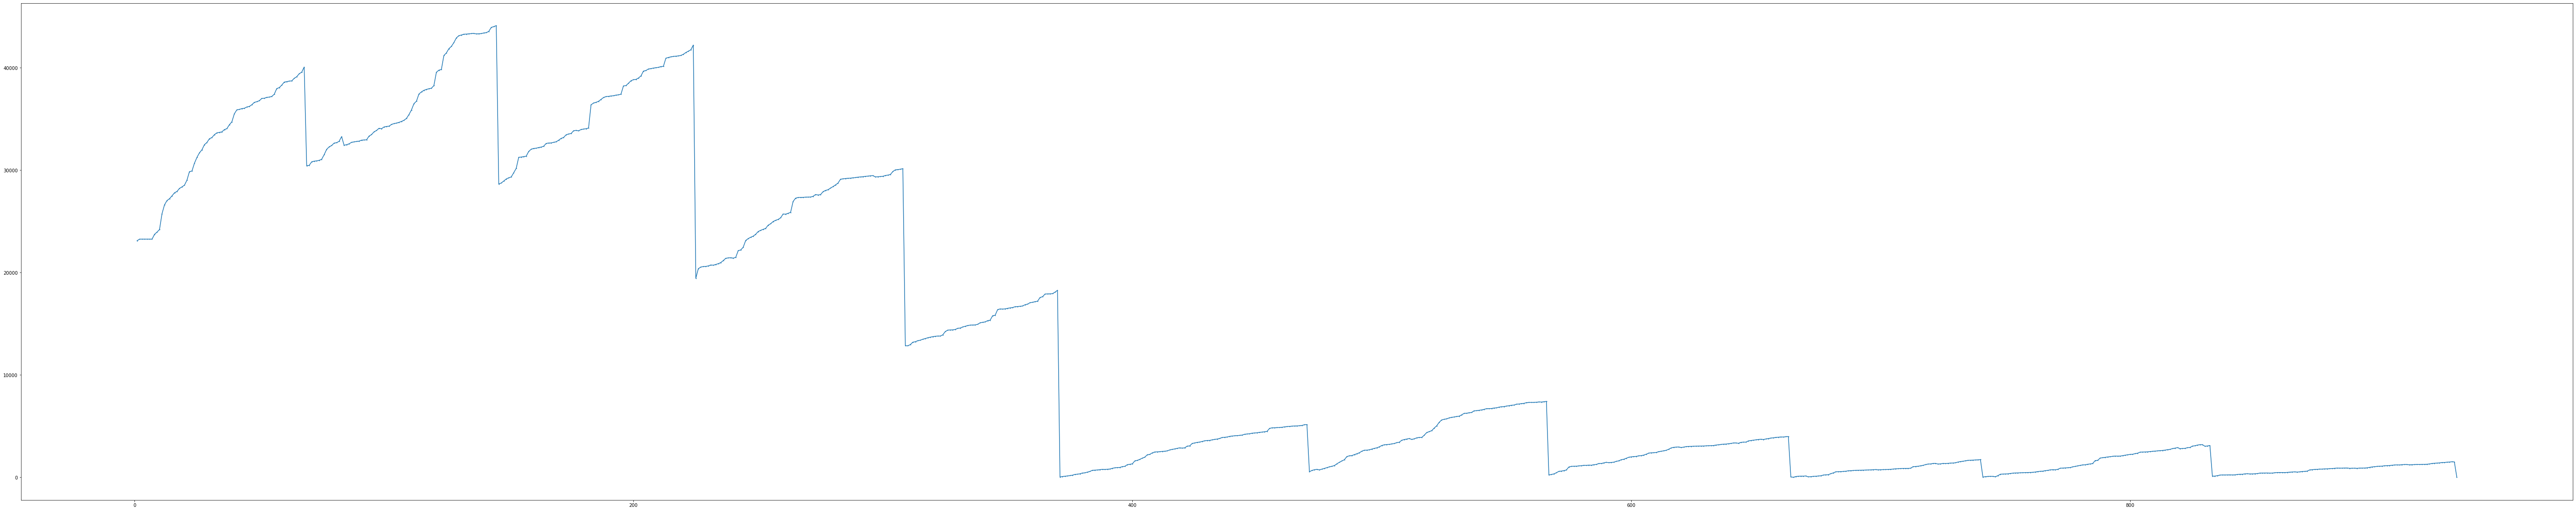

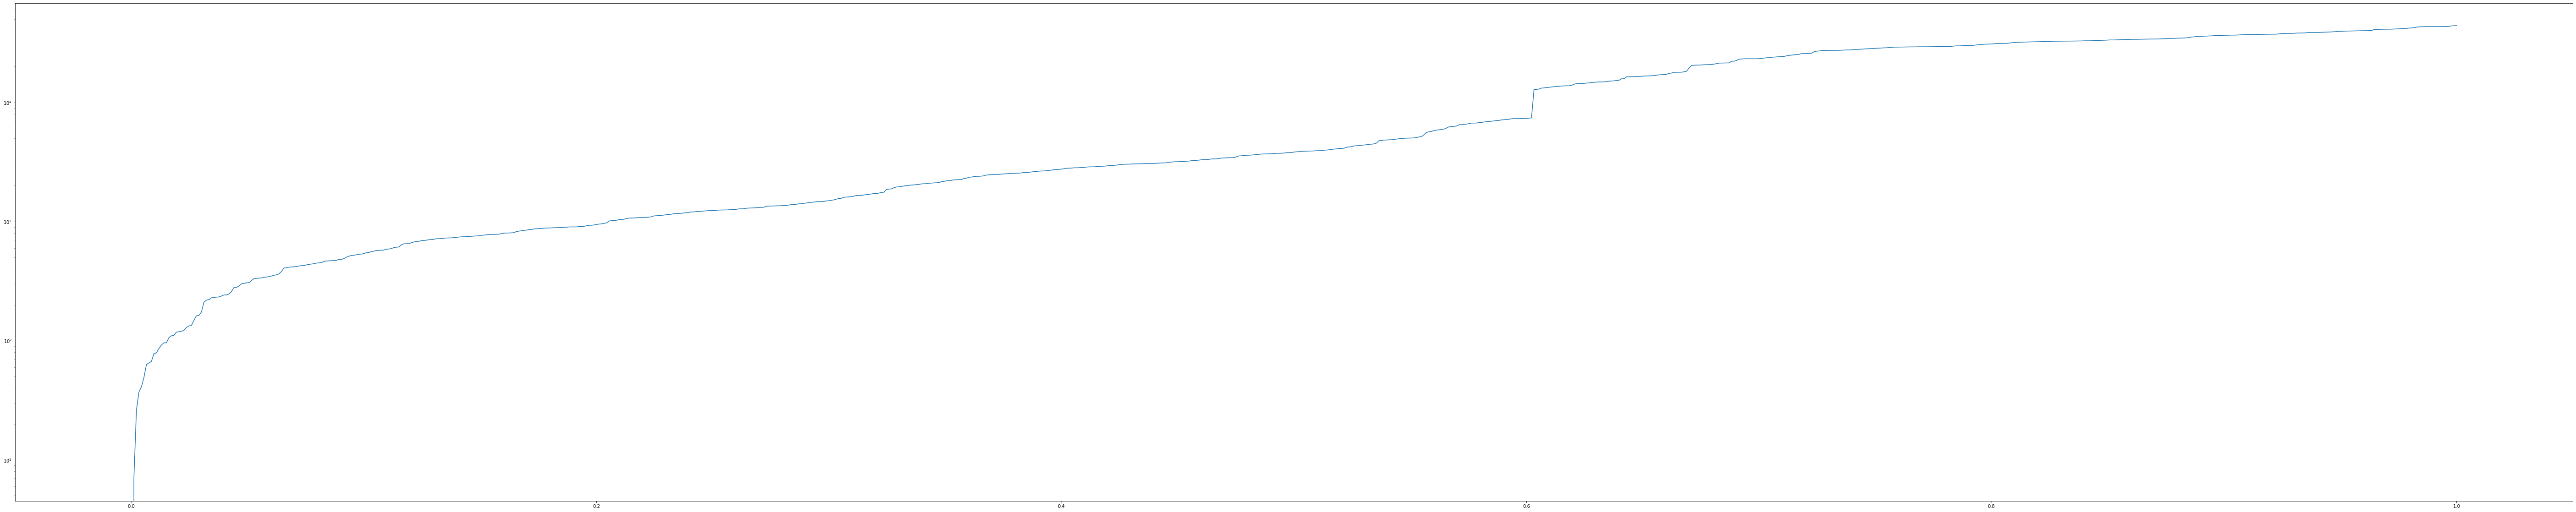

Warning data was received by a consumer after the filtered data was received: avg = 13147.58 ms; median 3834.00 ms; std = 14581.23 ms, further min was -1 ms and max 44100 ms
Produced -> Warnings


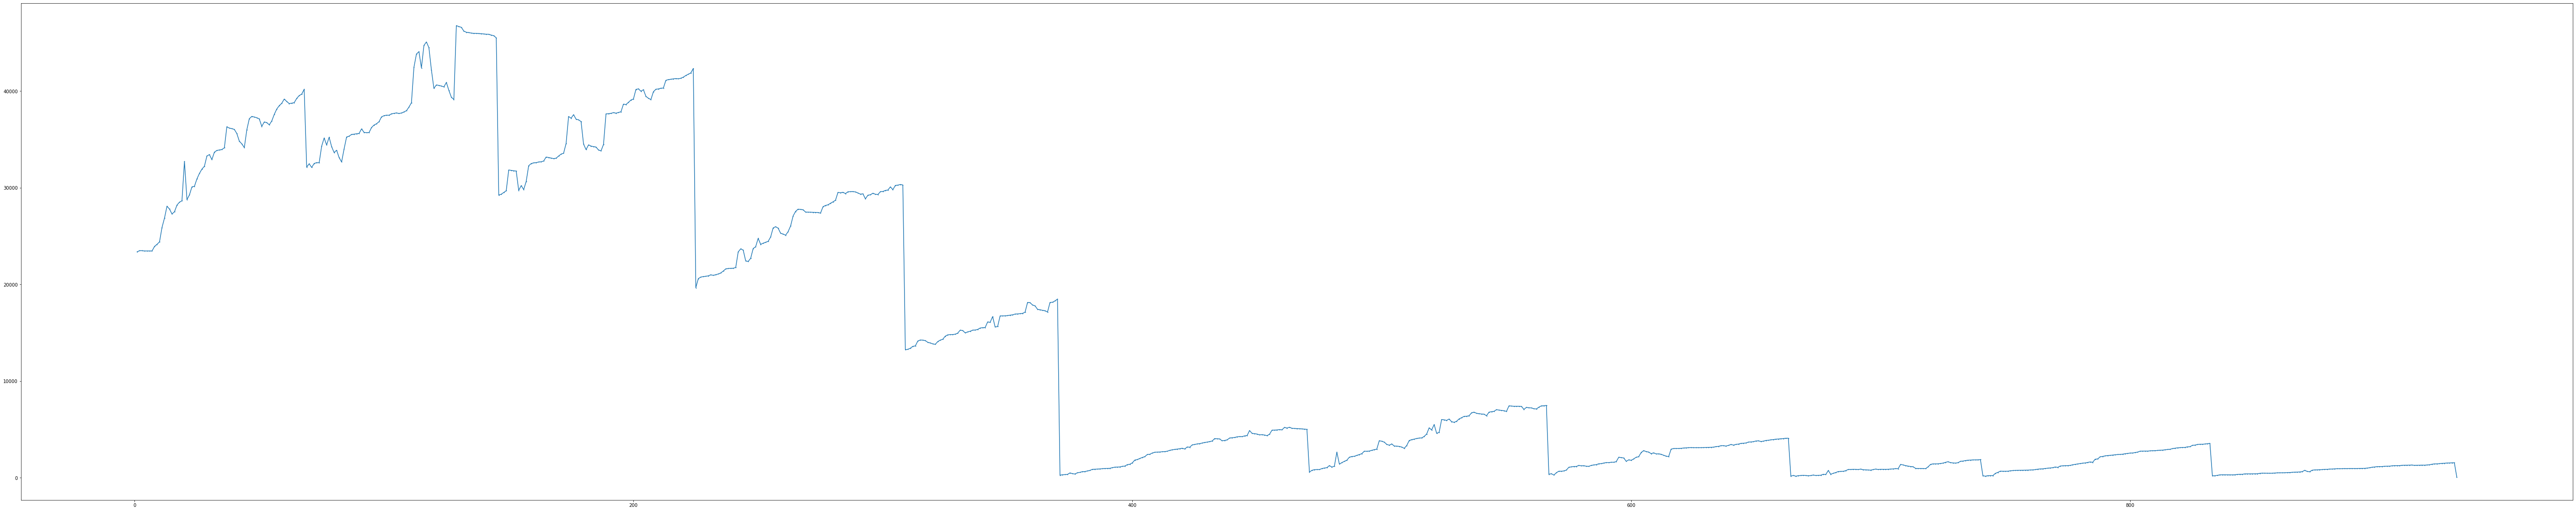

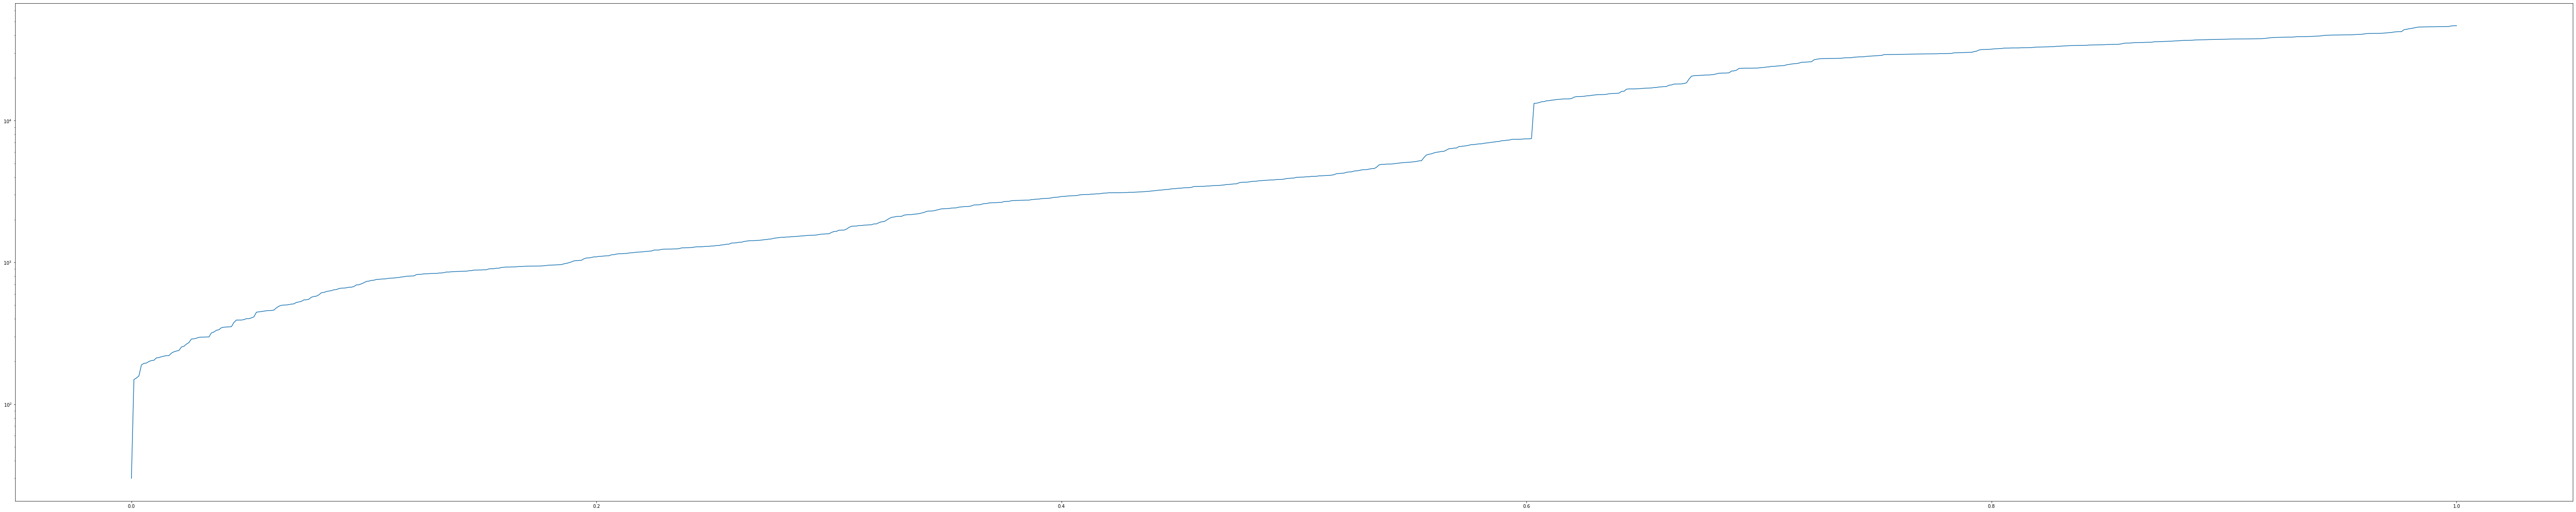

Warnings data was received by a consumer after the produced data was received: avg = 13514.48 ms; median 3936.00 ms; std = 14959.80 ms, further min was 30 ms and max 46761 ms


In [12]:
#In warnings Record.BeginOffset and Record.EndOffset are the related filtered offsets! There is no guarantee that these values are the same!!
warnings_filtered_joined = warnings_df.set_index("Record.BeginOffset").join(filtered_df.add_prefix('fb_').set_index("fb_Kafka.Offset")).set_index("Record.EndOffset").join(filtered_df.add_prefix('fe_').set_index("fe_Kafka.Offset"))

print("Filtered -> Warning")
diff = (warnings_filtered_joined["Consumer.Time"] - warnings_filtered_joined["fb_Consumer.Time"]).to_numpy()
diff = removeNaN(diff)
print("Warning data was received by a consumer after the filtered data was received: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %extractAvgMedStdMinMaxFromArray(diff))

print("Produced -> Warnings")
diff, prod_warning_join = extractDiffBetweenTwoTables(warnings_filtered_joined, produced_recieved_df.add_prefix('pr_'), 'fb_Data.Offset', 'pr_Kafka.Offset', "pr_Consumer.Time", 'Consumer.Time', 'pr_Consumer.Time')
diff = removeNaN(diff)
print("Warnings data was received by a consumer after the produced data was received: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %extractAvgMedStdMinMaxFromArray(diff))

## Data loss produced to filter

In [13]:
def calcDataLoss(df1, df1OffsetColumn, df2, df2OffsetColumn):
    df1Offsets = df1.to_numpy()[:,df1OffsetColumn].astype(int)
    df2Offsets = df2.to_numpy()[:,df2OffsetColumn].astype(int)
    
    errors = {}
        
    count = {}
    
    for x in df1Offsets:
        
        count[x] = 0

        
        #count = np.sum(df2Offsets == x)
        
        #if(count != 1):
        #    errors[count] = errors.get(count, 0) + 1
        
    for x in df1Offsets:
        count[x] = count[x] + 1
        
    for k, v in count.items():
        if v != 1:
            errors[count] = errors.get(count, 0) + 1
    
    out = "Received records "
    losses = False
    for k, v in errors.items():
        out += "%ix for %i times; " %(k,v)
        losses = True
    
    if(losses):
        print(out)
    else:
        print("The expected data was received exactly once.")
    
calcDataLoss(produced_generated_df, 0, filtered_df, 3)    

The expected data was received exactly once.


## Latency produced - warning

As the filter uses a median filter with size 5 it needs 3 outliers to detect a change. otherwise it is just skipped. ==> there must be a latency of at least (3*5ms) = 15ms

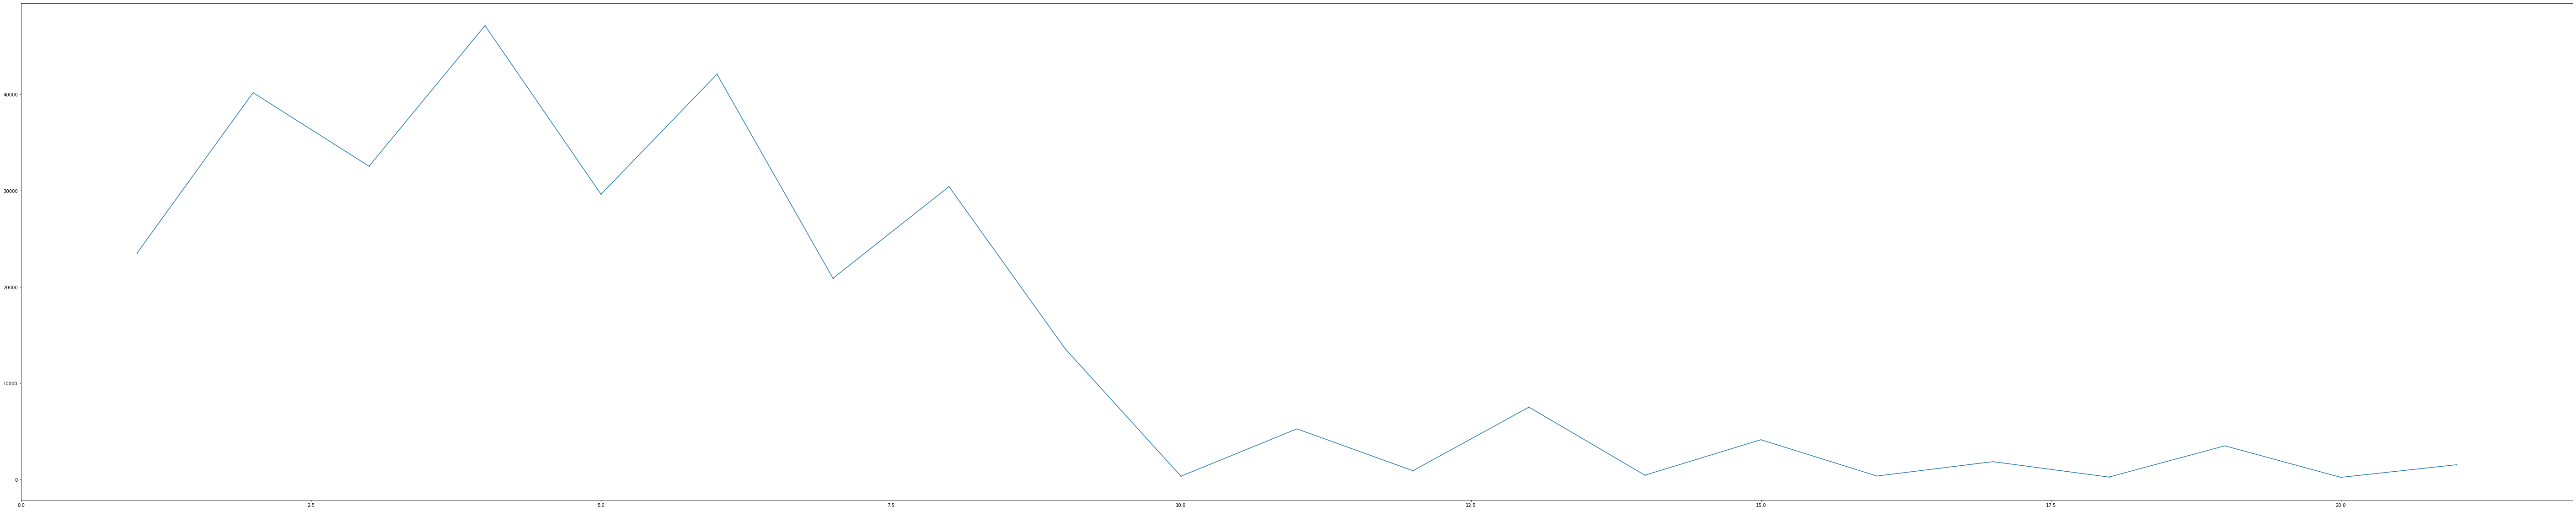

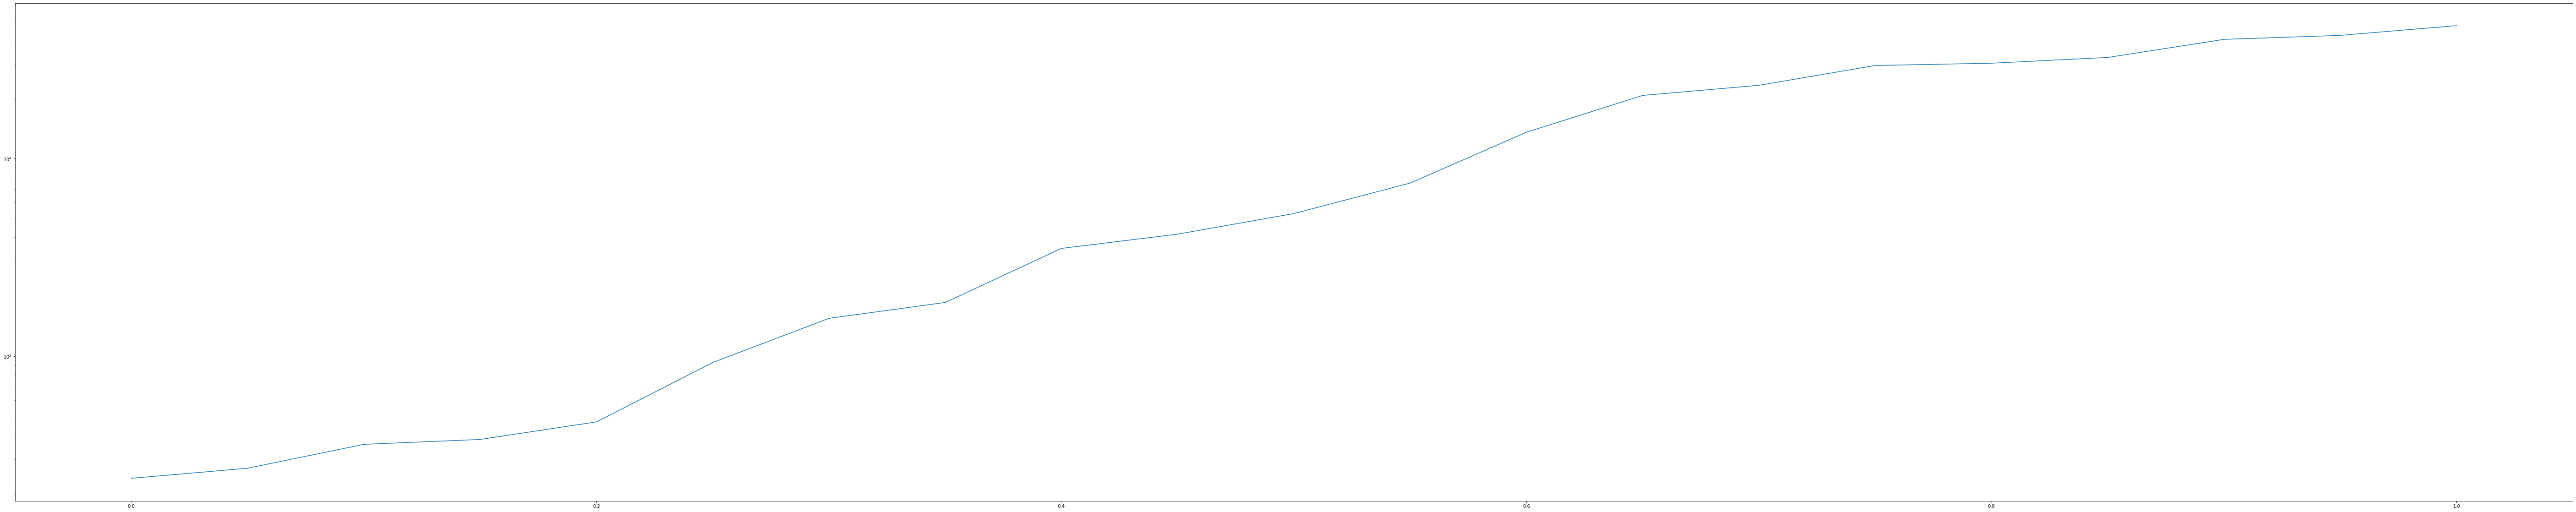

Anomalies were detected by Kafka after: avg = 14598.57 ms; median 5275.00 ms; std = 15873.80 ms, further min was 241 ms and max 47137 ms


In [35]:

#received and produced
pr_rc = produced_generated_df.add_prefix('pg_').set_index("pg_ProducedElements").join(produced_recieved_df.add_prefix('pr_').set_index("pr_Kafka.Offset"))

#only the changes
mc_pg_pr = modelchange_df.add_prefix('mc_').set_index("mc_producedElements").join(pr_rc)

#merge with warnings
fullJoin = mc_pg_pr.add_prefix('pd_').set_index("pd_pg_Kafka.Offset").join(prod_warning_join.add_prefix('pwj_'))



#warnings consum time
diff = (fullJoin['pwj_a_Consumer.Time'] - fullJoin['pd_pg_Producer.Timestamp']).to_numpy()

diff = removeNaN(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %extractAvgMedStdMinMaxFromArray(diff))

In [16]:
#offset = 25101
#range = 5
#pr_rc[(pr_rc["pg_Kafka.Offset"] > offset - range) & (pr_rc["pg_Kafka.Offset"] < offset + range)]
#filtered_df[(filtered_df["Data.Offset"] > offset - range) & (filtered_df["Data.Offset"] < offset + range)]

# Old Version

Didn't match all recognized changes! With 0 weren't matched:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

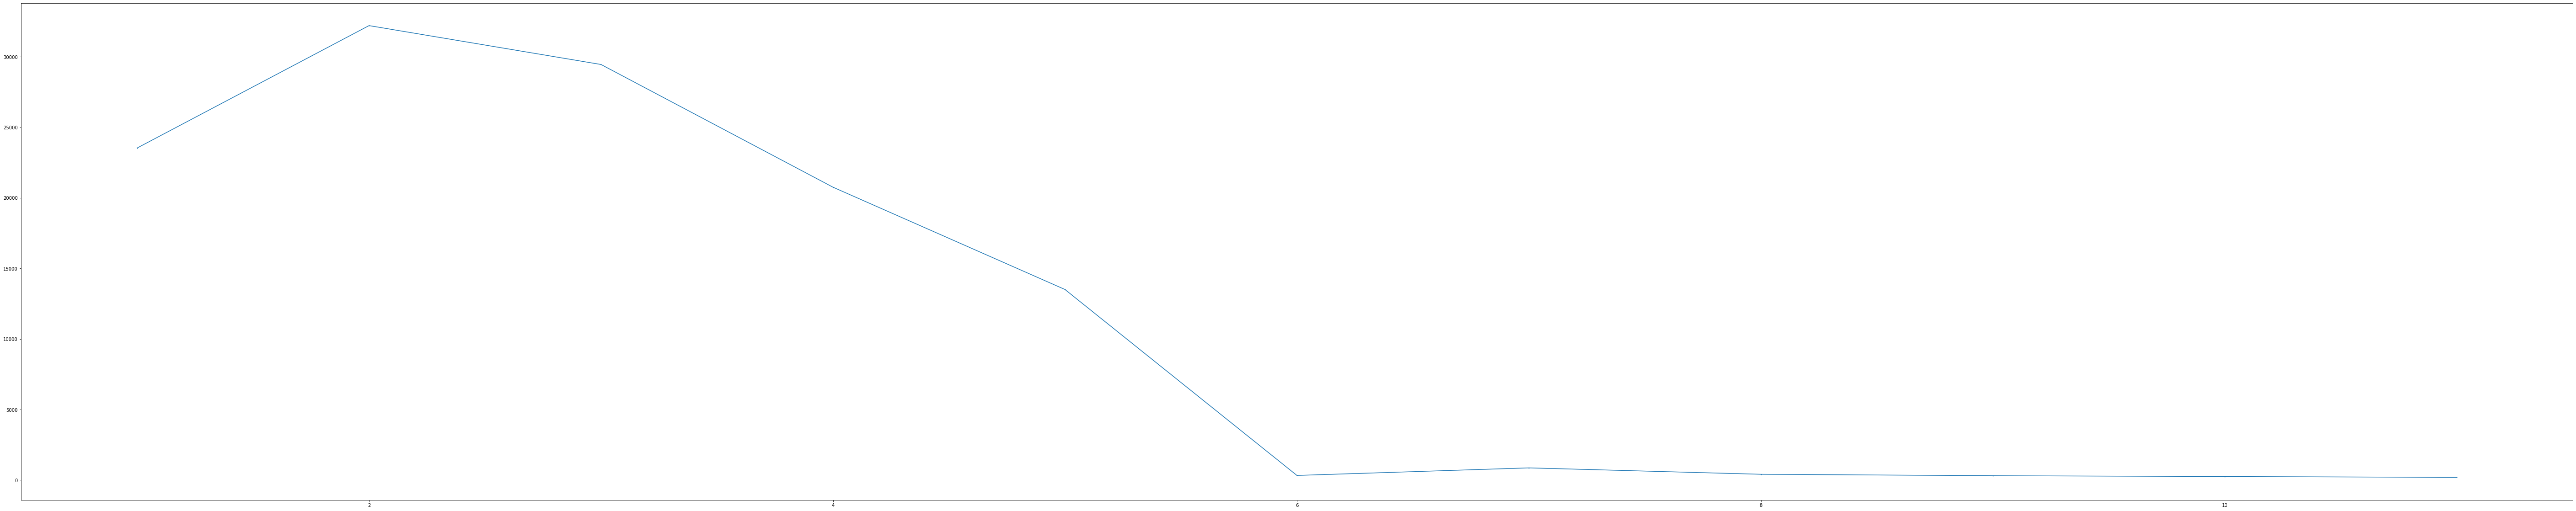

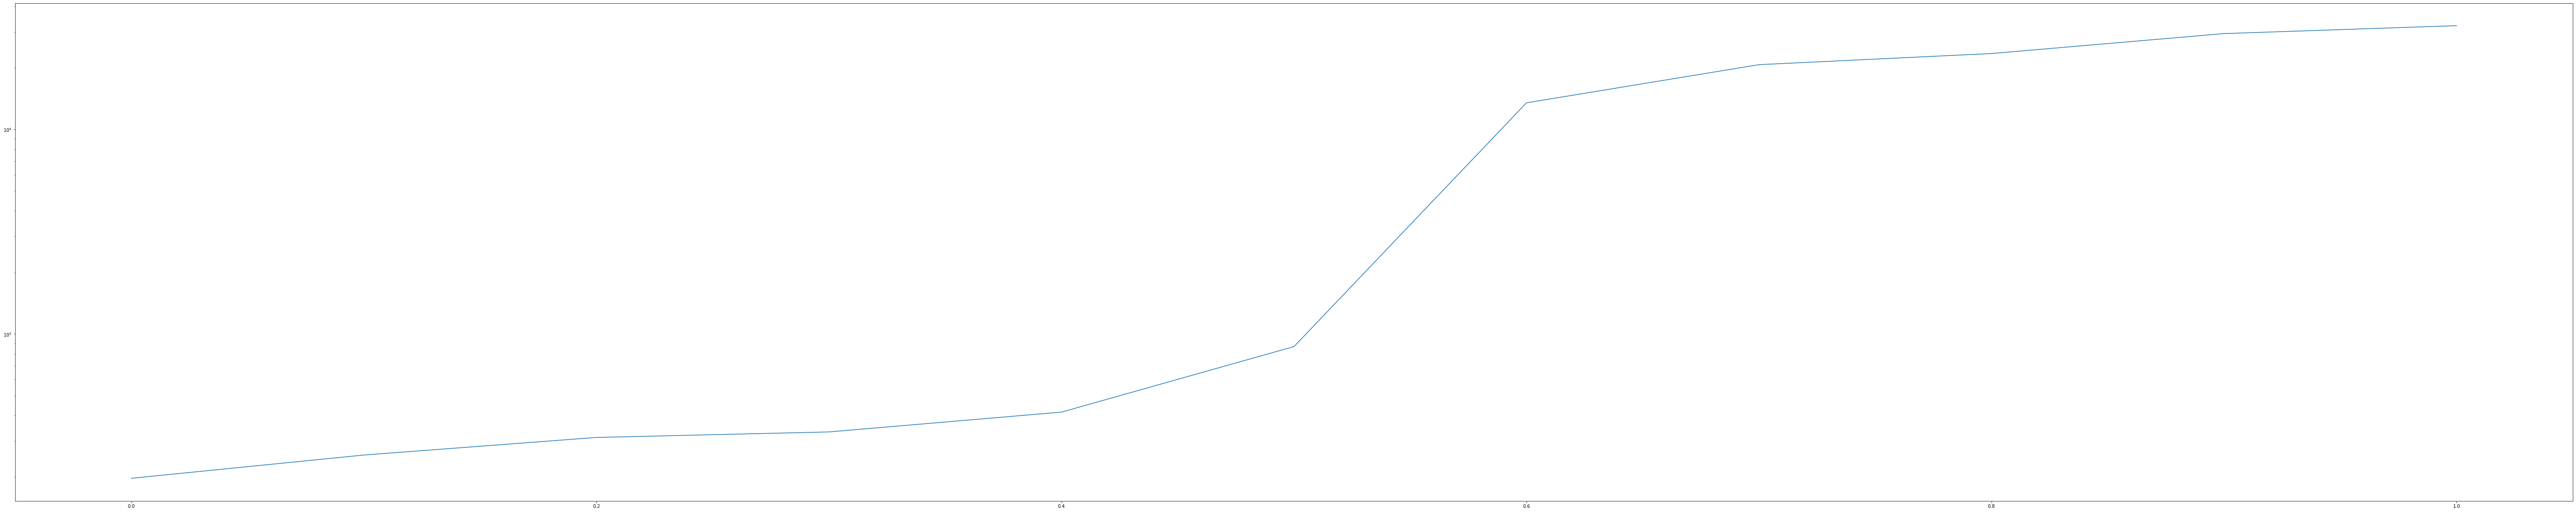

Anomalies were detected by Kafka after: avg = 11073.27 ms; median 868.00 ms; std = 12514.31 ms, further min was 197 ms and max 32199 ms


In [36]:
def calcLatencyProduceWarning(modelchange_df, warnings_df):
    m = modelchange_df.to_numpy()
    w = warnings_df.to_numpy()
    lastChange = m[0]

    open = False
    s = None
    
    diff = []
    
    for x in m:
        if int(x[1]) == 0 :
            open = False
            
            # search warnings
            a = w[:,6] >= lastChange[0]

            b = w[:,7] <= x[0]
            
            inner = np.logical_and(a,b)
            
            leftOuter = np.logical_and(w[:,6] <= lastChange[0], w[:,7] >= lastChange[0])
            rightOuter = np.logical_and(w[:,6] <= x[0], w[:,7] >= x[0])

            fullRange = np.logical_or(leftOuter, inner)
            fullRange = np.logical_or(fullRange, rightOuter)
            
            if s is None:
                fullRange.astype(int)
                s = fullRange
            else:
                s = np.add(s,fullRange.astype(int))
            
            matching = w[fullRange]     
            
            #first recognition
            r = min(matching[:,0])
            diff.append(r - lastChange[0])
            
        else:
            #skip two changes without a reset
            if not open:
                lastChange = x
            open = True
        
    if not np.all(s == 1):
        print("Didn't match all recognized changes! With 0 weren't matched:")
        with np.printoptions(threshold=np.inf):
            print(s)
        
    diff = np.array(diff)
    return extractAvgMedStdMinMaxFromArray(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %calcLatencyProduceWarning(modelchange_df, warnings_df))

def calcLatencyProduceWarning(modelchange_df, warnings_df, amplitude, periodLength):
    m = modelchange_df.to_numpy()
    w = warnings_df.to_numpy()
    lastChange = m[0]

    open = False
    s = None
    
    diff = []
    
    for x in m:
        if x[1] == amplitude and x[2] == periodLength:
            open = False
            
            # search warnings
            a = w[:,6] >= lastChange[0]

            b = w[:,7] <= x[0]
            
            inner = np.logical_and(a,b)
            
            leftOuter = np.logical_and(w[:,6] <= lastChange[0], w[:,7] >= lastChange[0])
            rightOuter = np.logical_and(w[:,6] <= x[0], w[:,7] >= x[0])

            fullRange = np.logical_or(leftOuter, inner)
            fullRange = np.logical_or(fullRange, rightOuter)
            
            if s is None:
                fullRange.astype(int)
                s = fullRange
            else:
                s = np.add(s,fullRange.astype(int))
            
            matching = w[fullRange]     
            
            #first recognition
            r = min(matching[:,0])
            diff.append(r - lastChange[0])
            
        else:
            #skip two changes without a reset
            if not open:
                lastChange = x
            open = True
        
    if not np.all(s == 1):
        print("Didn't match all recognized changes! With 0 weren't matched:")
        with np.printoptions(threshold=np.inf):
            print(s)
        
    diff = np.array(diff)
    
    return extractAvgMedStdMinMaxFromArray(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %calcLatencyProduceWarning(modelchange_df, warnings_df, 3, 1000))